In [284]:
import os
import json
import numpy as np
import torch
import nni
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader, Classification
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context
from tqdm import tqdm
from IPython.display import clear_output

from sklearn.preprocessing import OneHotEncoder
import re
import io
from graphviz import Digraph
from IPython.display import display
import matplotlib.pyplot as plt

import scipy.stats as sps

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [169]:

DARTS_OPS = [
        'none',
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5',
    ]

encoder = OneHotEncoder(handle_unknown='ignore')


In [170]:
encoder = OneHotEncoder(handle_unknown='ignore')
ops_array = np.array(DARTS_OPS).reshape(-1, 1)

DARTS_OPS_ONE_HOT = encoder.fit_transform(ops_array).toarray()

print(DARTS_OPS_ONE_HOT)

[[0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [171]:
def load_json_from_directory(directory_path):
    """
    Обходит директорию и создает список словарей из JSON файлов.

    Аргументы:
        directory_path (str): Путь к директории, содержащей JSON файлы.

    Возвращает:
        list: Список словарей, загруженных из JSON файлов.
    """
    json_data = []
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.json'):
                file_path = os.path.join(root, file)
                with open(file_path, 'r', encoding='utf-8') as f:
                    try:
                        data = json.load(f)
                        json_data.append(data)
                    except json.JSONDecodeError as e:
                        print(f"Error decoding JSON from file {file_path}: {e}")
    return json_data

In [172]:
models_dict = load_json_from_directory('first_dataset/')

Посмотрим как распределена точность моделей

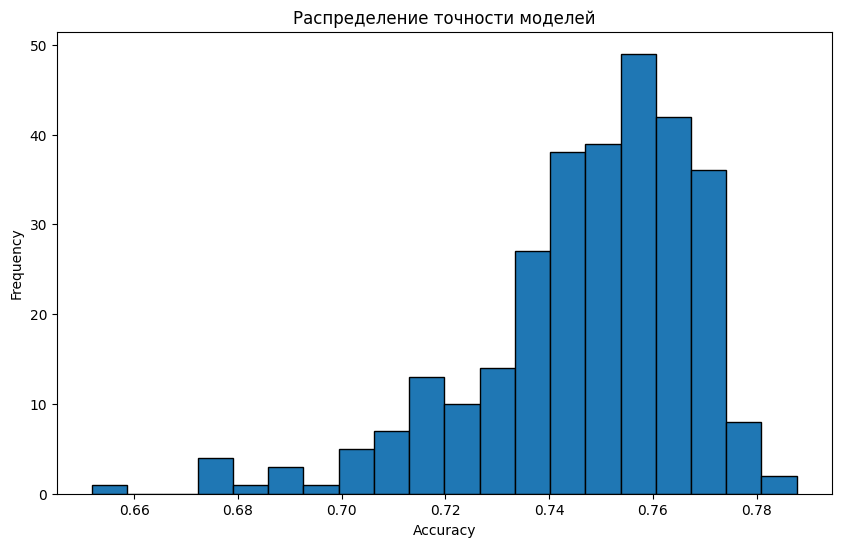

In [306]:
accuracies = [model['test_accuracy'] for model in models_dict]

plt.figure(figsize=(10, 6))

plt.hist(accuracies, bins=20, edgecolor='black')
plt.title('Распределение точности моделей')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

In [173]:
def extract_cells(arch_dict):
    normal_cell, reduction_cell = [], []
    tmp_list = []

    for key, value in arch_dict["architecture"].items():
        if key.startswith("normal/") or key.startswith("reduce/"):
            tmp_list.extend([key, value])

        if len(tmp_list) == 4:
            tmp_list.pop(2)
            if key.startswith("normal/"):
                normal_cell.append(tmp_list)
            else:
                reduction_cell.append(tmp_list)
            tmp_list = []

    return normal_cell, reduction_cell

In [225]:
class Vertex:
    def __init__(self, op, in_channel, out_channel):
        self.op = op
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.op_one_hot = DARTS_OPS_ONE_HOT[DARTS_OPS.index(op)]

    def __str__(self):
        return f"Op: {self.op} | In: {self.in_channel} | Out: {self.out_channel}"
    def __repr__(self):
        return self.__str__()

In [ ]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, model_dict):
        self.model_dict = model_dict
        self.normal_cell, self.reduction_cell = extract_cells(model_dict)

        self.normal_graph = self.make_graph(self.normal_cell)
        self.reduction_graph = self.make_graph(self.reduction_cell)

        self.normal_num_vertices, self.reduction_num_vertices = self.__len__()

    def __len__(self):
        max_normal_out = max(vertex.out_channel for vertex in self.normal_graph)
        max_reduction_out = max(vertex.out_channel for vertex in self.reduction_graph)
        return (max_normal_out, max_reduction_out)

    def make_graph(self, cell):
        graph = []
        for value in cell:
            in_channel = int(value[2][0])
            out_channel = int(re.search(r"op_(\d+)_", value[0]).group(1))
            op = value[1]
            graph.append(Vertex(op, in_channel, out_channel))
        graph.append(Vertex("none", 0, 0))
        graph.append(Vertex("none", 1, 1))

        graph.sort(key=lambda vertex: (vertex.in_channel, vertex.out_channel))

        return graph

    def show_graph(self, cell_type="normal"):
        # Выбираем целевой граф
        if cell_type == "normal":
            graph = self.normal_graph
            graph_name = "Normal Cell"
        else:
            graph = self.reduction_graph
            graph_name = "Reduction Cell"

        # Создаем объект Digraph
        dot = Digraph(comment=graph_name, format="png")
        dot.attr(rankdir="TB")  # Ориентация графа: сверху вниз (TB)

        # Добавляем узлы
        for idx, vertex in enumerate(graph):
            label = (
                f"{{Op: {vertex.op} | "
                f"In: {vertex.in_channel} | "
                f"Out: {vertex.out_channel}}}"
            )
            dot.node(str(idx), label=label, shape="record")

        # Добавляем связи между узлами
        connections = set()
        for src_idx, src_vertex in enumerate(graph):
            for dst_idx, dst_vertex in enumerate(graph):
                # Связь существует, если out_channel источника совпадает с in_channel приемника
                if src_vertex.out_channel == dst_vertex.in_channel:
                    if (src_idx, dst_idx) not in connections:
                        dot.edge(str(src_idx), str(dst_idx))
                        connections.add((src_idx, dst_idx))

        # Рендерим граф в Jupyter Notebook
        display(dot)

    def get_normal_graph(self):
        return self.normal_graph

    def get_reduction_graph(self):
        return self.reduction_graph

    def _get_graph_cell_by_type(self, cell_type="normal"):
        if cell_type == "normal":
            return self.normal_graph, self.normal_cell

        return self.reduction_graph, self.reduction_cell

    def get_adjacency_matrix(self, cell_type="normal"):
        graph, _ = self._get_graph_cell_by_type(cell_type)

        if cell_type == "normal":
            adj_matrix = np.zeros(
                shape=(self.normal_num_vertices + 1, self.normal_num_vertices + 1)
            )
        else:
            adj_matrix = np.zeros(
                shape=(self.reduction_num_vertices + 1, self.reduction_num_vertices + 1)
            )

        operations = []
        operations_one_hot = []
        for vertex in graph:
            adj_matrix[vertex.in_channel, vertex.out_channel] = 1
            operations.append(vertex.op)
            operations_one_hot.append(vertex.op_one_hot)

        return adj_matrix, operations, operations_one_hot

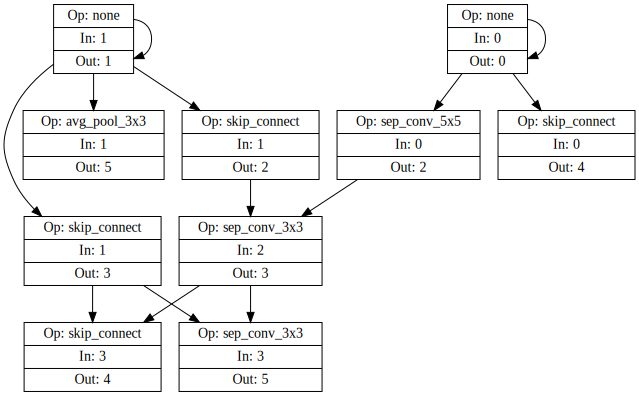

In [305]:
graph = GraphDataset(models_dict[0])
graph.show_graph()

In [246]:
models_dict[0].keys()

dict_keys(['architecture', 'test_predictions', 'test_accuracy'])

In [289]:
def get_get_diversity(model_dict_1, model_dict_2):
    model_1_answers = np.array(model_dict_1["test_predictions"])
    model_2_answers = np.array(model_dict_2["test_predictions"])

    return np.mean(model_1_answers == model_2_answers)

In [291]:
diversity_matrix = np.zeros((len(models_dict), len(models_dict))) + np.eye(
    len(models_dict)
)

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversity_matrix[i, j] = get_get_diversity(models_dict[i], models_dict[j])
        diversity_matrix[j, i] = diversity_matrix[i, j]

100%|██████████| 300/300 [00:58<00:00,  5.11it/s]


100%|██████████| 300/300 [00:00<00:00, 19409.99it/s]


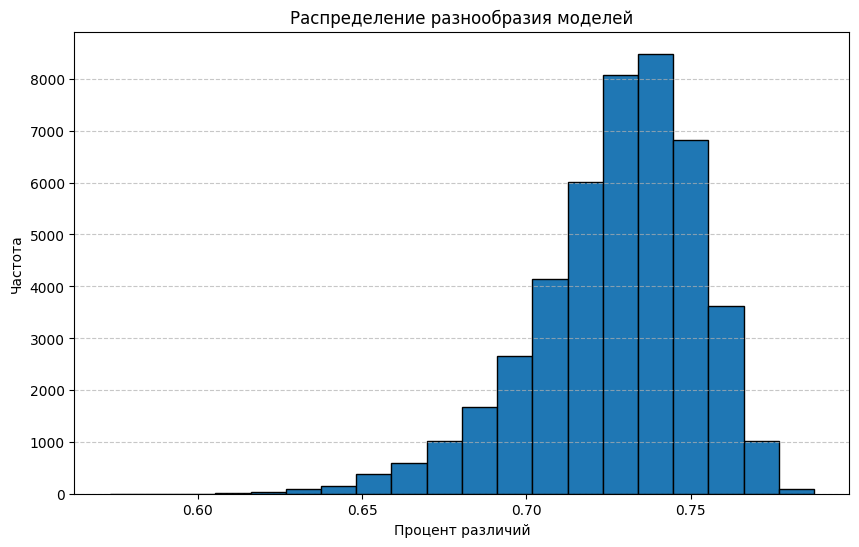

In [308]:
diversities = []

for i in tqdm(range(len(models_dict))):
    for j in range(i + 1, len(models_dict)):
        diversities.append(diversity_matrix[i, j])
diversities = np.array(diversities)

plt.figure(figsize=(10, 6))

plt.hist(diversities, bins=20, edgecolor="black")
plt.title("Распределение разнообразия моделей")
plt.xlabel("Процент различий")
plt.ylabel("Частота")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [301]:
def find_postive_negative(index, models_dict, diversity_matrix):
    positive = []
    negative = []
    margin = np.quantile(diversity_matrix[:, index], 0.75)
    print(margin)
    for i in range(len(models_dict)):
        if diversity_matrix[i, index] > margin:
            positive.append(i)
        else:
            negative.append(i)

    return positive, negative

In [302]:
postive, negative = find_postive_negative(228, models_dict, diversity_matrix)

0.7493


In [304]:
adj_martrices = []
one_hot_operations = []
for model in tqdm(models_dict):
    graph = GraphDataset(model)
    adj_martrices.append(graph.get_adjacency_matrix()[0])
    one_hot_operations.append(graph.get_adjacency_matrix()[2])

100%|██████████| 300/300 [00:00<00:00, 6147.09it/s]
